In [46]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pathlib import Path

In [47]:
#creating the data
torch.manual_seed(63)
init_weight = 0.3
init_bias = 0.9
start = 0 
end = 300
step = 0.5
X = torch.arange(start,end,step).unsqueeze(dim=1)
Y = init_weight * X + init_bias
X.shape,Y.shape

(torch.Size([600, 1]), torch.Size([600, 1]))

In [48]:
X[:5],Y[:5]

(tensor([[0.0000],
         [0.5000],
         [1.0000],
         [1.5000],
         [2.0000]]),
 tensor([[0.9000],
         [1.0500],
         [1.2000],
         [1.3500],
         [1.5000]]))

In [49]:
X_train,X_test ,Y_train, Y_test = train_test_split(X,Y, test_size= 0.2, random_state=4)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([480, 1]),
 torch.Size([480, 1]),
 torch.Size([120, 1]),
 torch.Size([120, 1]))

[]

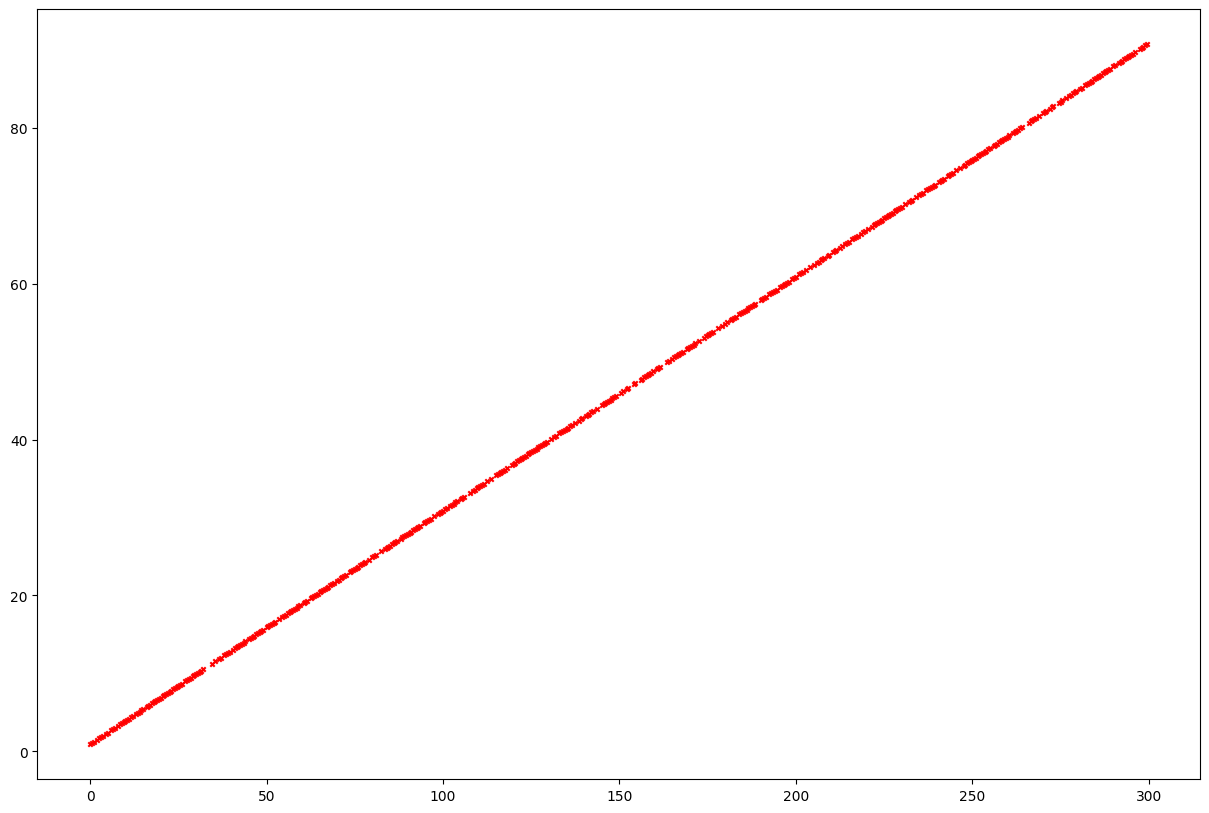

In [50]:
#Viz the data
plt.figure(figsize = (15,10))
plt.scatter(X_train,Y_train, c ='r', s=10, marker= 'x' )
plt.plot()

In [51]:
class LinearRegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float))
        self.bias =  nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float))
        
    def forward(self,X):
        return  self.weight * X * self.bias

In [52]:
model = LinearRegressionNN()
print(list(model.parameters()))
print(model.state_dict())

[Parameter containing:
tensor([-1.1845], requires_grad=True), Parameter containing:
tensor([0.2166], requires_grad=True)]
OrderedDict([('weight', tensor([-1.1845])), ('bias', tensor([0.2166]))])


In [53]:
epoch = 600
loss_func = nn.L1Loss()
lr = 0.001
optm = torch.optim.Adam(params = model.parameters(),lr = lr)
epoch_list = []
train_loss = []
test_loss_list = []

for epoch in range(epoch):
    model.train()
    train_pred = model(X_train)
    loss = loss_func(train_pred, Y_train)
    optm.zero_grad()
    loss.backward()
    optm.step()
    model.eval()
    
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_func(test_pred, Y_test.type(torch.float))
        
        if epoch % 10 == 0:
            epoch_list.append(epoch)
            train_loss.append(loss.detach().numpy())
            test_loss_list.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train lost : = {loss:.2f} | MAE Test loss  = {test_loss:.2f}")

Epoch: 0 | MAE Train lost : = 83.35 | MAE Test loss  = 87.63
Epoch: 10 | MAE Train lost : = 81.29 | MAE Test loss  = 85.46
Epoch: 20 | MAE Train lost : = 79.27 | MAE Test loss  = 83.33
Epoch: 30 | MAE Train lost : = 77.28 | MAE Test loss  = 81.24
Epoch: 40 | MAE Train lost : = 75.33 | MAE Test loss  = 79.19
Epoch: 50 | MAE Train lost : = 73.42 | MAE Test loss  = 77.18
Epoch: 60 | MAE Train lost : = 71.56 | MAE Test loss  = 75.22
Epoch: 70 | MAE Train lost : = 69.73 | MAE Test loss  = 73.30
Epoch: 80 | MAE Train lost : = 67.94 | MAE Test loss  = 71.41
Epoch: 90 | MAE Train lost : = 66.18 | MAE Test loss  = 69.57
Epoch: 100 | MAE Train lost : = 64.46 | MAE Test loss  = 67.76
Epoch: 110 | MAE Train lost : = 62.78 | MAE Test loss  = 65.98
Epoch: 120 | MAE Train lost : = 61.12 | MAE Test loss  = 64.24
Epoch: 130 | MAE Train lost : = 59.50 | MAE Test loss  = 62.53
Epoch: 140 | MAE Train lost : = 57.90 | MAE Test loss  = 60.85
Epoch: 150 | MAE Train lost : = 56.33 | MAE Test loss  = 59.20
Epo

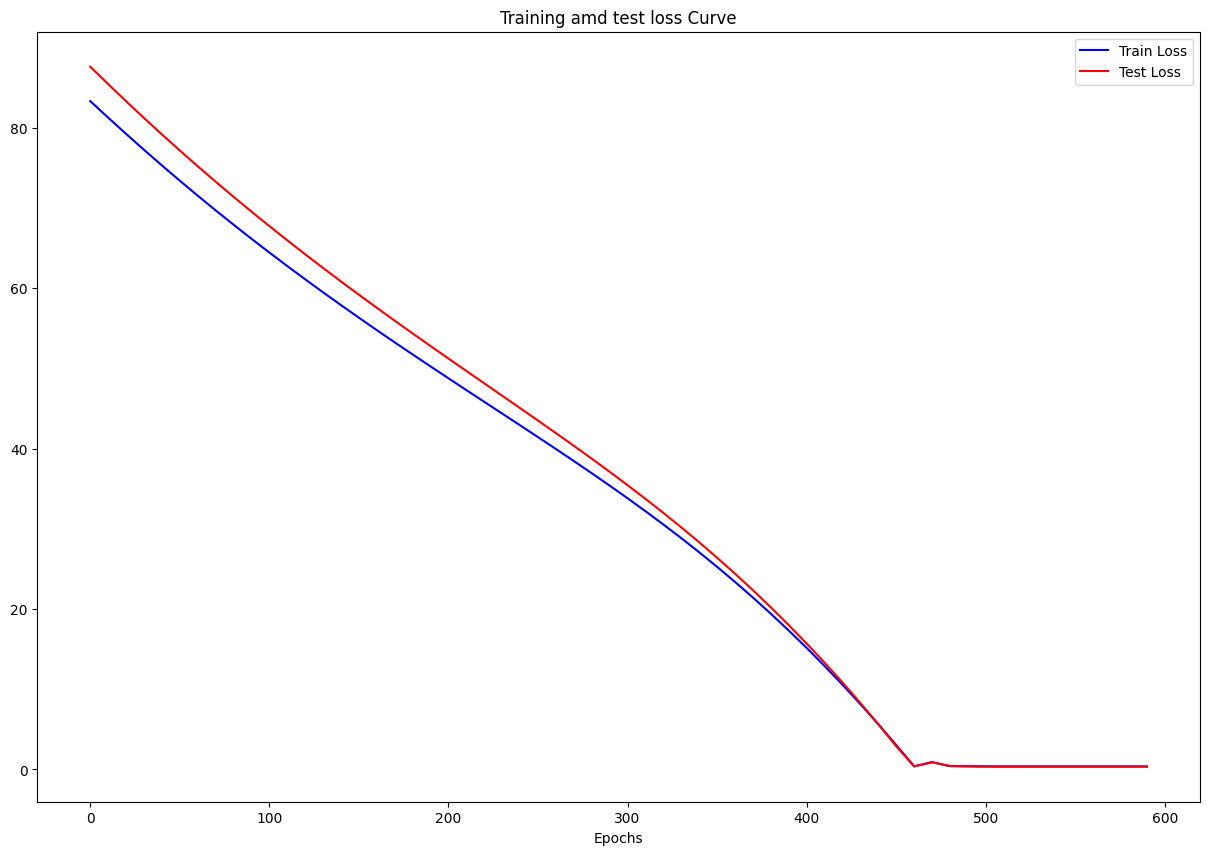

In [54]:
plt.figure(figsize = (15,10))
plt.plot(epoch_list,train_loss, c = 'b', label= "Train Loss")
plt.plot(epoch_list, test_loss_list, c = 'r', label= "Test Loss")
plt.title("Training amd test loss Curve")
plt.xlabel("Epochs")
plt.legend();

In [55]:
model.state_dict()

OrderedDict([('weight', tensor([-1.2627])), ('bias', tensor([-0.2409]))])

##  **GPU TENSORS PRAT**

In [56]:
torch.cuda.manual_seed(66)
class NewLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=1,out_features=1)
    
    def forward(self,X):
        return self.linear(X)

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
linearmodel = NewLinear()
print(linearmodel.state_dict())

cpu
OrderedDict([('linear.weight', tensor([[-0.3591]])), ('linear.bias', tensor([-0.3047]))])


In [58]:
next(linearmodel.parameters()).device

device(type='cpu')

In [59]:
linearmodel.to(device)
next(linearmodel.parameters()).device

device(type='cpu')

In [60]:
#moving data to cuda/gpu
X_train_gpu = X_train.to(device)
X_test_gpu = X_test.to(device)
Y_train_gpu = Y_train.to(device)
Y_test_gpu = Y_test.to(device)

In [61]:
epoch = 600
epoch_gpu = []
train_gpu = []
test_gpu = []
gpu_lr = 0.01
loss_func_gpu = nn.L1Loss()
optimizer = torch.optim.Adam(params = linearmodel.parameters(),lr = gpu_lr)

for epochgpu in range(epoch):
    linearmodel.train()
    train_pred_gpu = linearmodel(X_train_gpu)
    train_loss_gpu = loss_func_gpu(train_pred_gpu,Y_train_gpu)
    optimizer.zero_grad()
    train_loss_gpu.backward()
    optimizer.step()
    
    linearmodel.eval()
    with torch.inference_mode():
        test_gpu_pred = linearmodel(X_test_gpu)
        test_gpu_loss = loss_func(test_gpu_pred, Y_test_gpu)
        
        if epochgpu % 100 == 0:
            epoch_gpu.append(epochgpu)
            train_gpu.append(train_loss_gpu.cpu().detach().numpy())
            test_gpu.append(test_gpu_loss.cpu().detach().numpy())
            print(f"Epoch -> {epochgpu} || MAE Train loss -> {train_loss_gpu:.2f} MAE Test loss -> {test_gpu_loss:.2f}")

print("Training Done")

Epoch -> 0 || MAE Train loss -> 98.84 MAE Test loss -> 102.60
Epoch -> 100 || MAE Train loss -> 0.49 MAE Test loss -> 0.19
Epoch -> 200 || MAE Train loss -> 0.13 MAE Test loss -> 0.10
Epoch -> 300 || MAE Train loss -> 0.01 MAE Test loss -> 0.12
Epoch -> 400 || MAE Train loss -> 0.21 MAE Test loss -> 0.08
Epoch -> 500 || MAE Train loss -> 0.22 MAE Test loss -> 0.02
Training Done


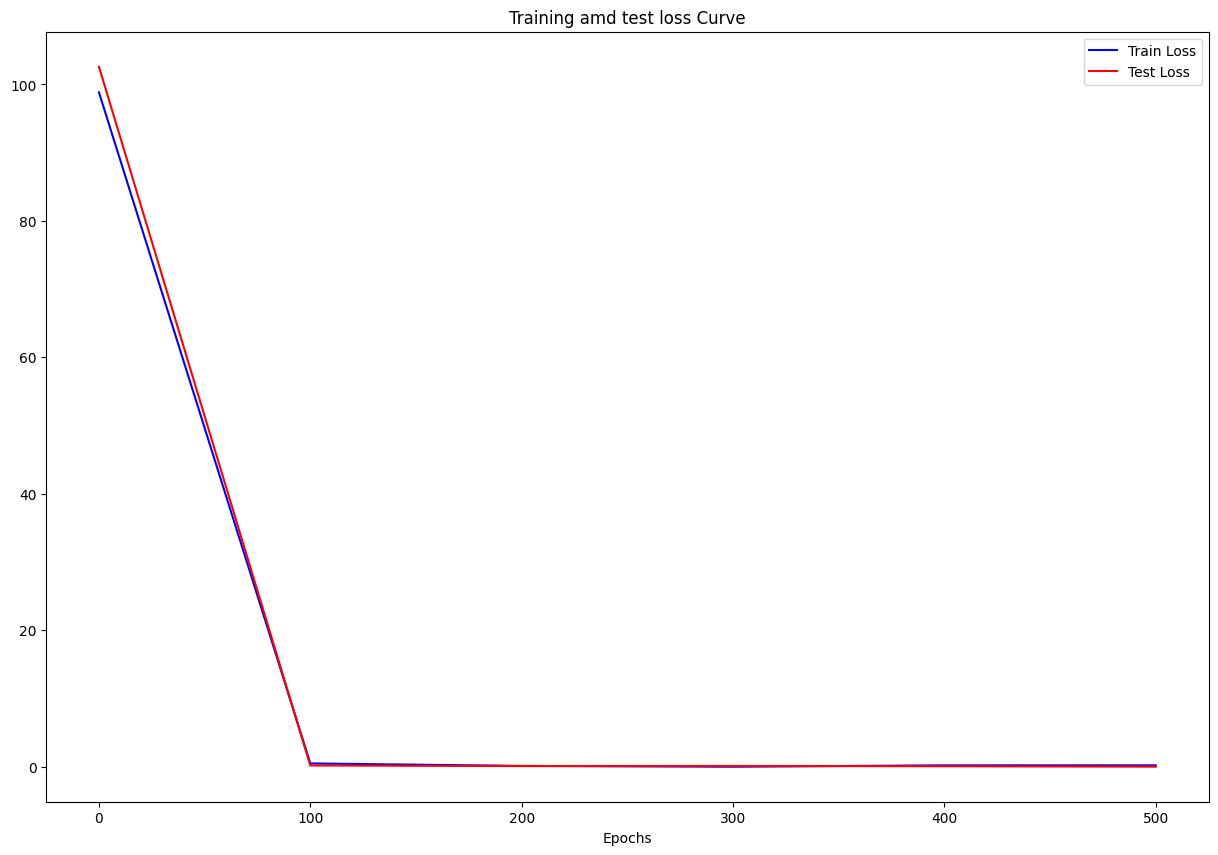

In [62]:
plt.figure(figsize= (15,10))
plt.plot(epoch_gpu, train_gpu, c = 'b', label= "Train Loss")
plt.plot(epoch_gpu, test_gpu, c = 'r', label= "Test Loss")
plt.title("Training amd test loss Curve")
plt.xlabel("Epochs")
plt.legend();

## **Saving and loadind a model**

In [63]:
model_path = Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_path

PosixPath('models')

In [64]:
model_name = "Linearmodel.pth"
model_save_path = model_path/model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj =linearmodel.state_dict(), f = model_save_path)
print("done")

Saving model to: models/Linearmodel.pth
done


In [65]:
!ls -l models/Linearmodel.pth

-rw-rw-rw- 1 codespace codespace 1143 May 18 20:32 models/Linearmodel.pth


In [66]:
torch.load(model_save_path)

OrderedDict([('linear.weight', tensor([[0.3000]])),
             ('linear.bias', tensor([0.8997]))])

In [67]:
new_model = NewLinear
new_model.load_state_dict(torch.load(model_save_path))
new_model.to(device)
print(f"Loade Model :\n {new_model}")
print(f"Model on device: \n {next(new_model.parameters()).device}")

TypeError: Module.load_state_dict() missing 1 required positional argument: 'state_dict'